<a href="https://colab.research.google.com/github/adenilso/sucupira-indicadores/blob/master/Sucupira_Indicadores_Quadrienal_2017_2020.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Código para geração dos gráficos

##Setup

In [1]:
from google.colab import files
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
import numpy as np
import io
from plotnine import *

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
estratos = ["A1", "A2", "A3", "A4", "B1", "B2", "B3", "B4"]
estratos.reverse()

In [3]:
pesos = dict({"B4": 0.05,
               "B3": 0.10,
               "B2": 0.20,
               "B1": 0.50,
               "A4": 0.625,
               "A3": 0.75, 
               "A2": 0.875,
               "A1": 1.0,
               "C": 0
              })

In [4]:
def carregar_planilhas(sheetnames):
  path = '/content/drive/My Drive/CAPES2018-2021/Quadrienal 2017-2020/Indicadores/'
  sheets = dict([[sn, pd.read_csv(path + 'CC-' + sn + '.csv', delimiter="\t",error_bad_lines=False)] for sn in sheetnames])
  return sheets

In [5]:
sheetnames = ['producoes_lista', 'docentes', 'TCC', 'programas', 'discentes']
sheets = carregar_planilhas(sheetnames)
producoes = sheets['producoes_lista']
docentes = sheets['docentes']
siglas = producoes.groupby(["Cod PPG", "IES Principal Sigla"]).size().reset_index().rename(columns={"IES Principal Sigla": "Sigla"})[["Cod PPG", "Sigla"]]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DtypeWarning: Columns (6,13,75) have mixed types.Specify dtype option on import or set low_memory=False.
  This is separate from the ipykernel package so we can avoid doing imports until
b'Skipping line 24408: expected 49 fields, saw 61\nSkipping line 24915: expected 49 fields, saw 61\n'
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DtypeWarning: Columns (6,31) have mixed types.Specify dtype option on import or set low_memory=False.
  This is separate from the ipykernel package so we can avoid doing imports until


## Funcões de Sumarização

In [6]:
def sumarizar_docs(docs):
  res = pd.DataFrame({"Cod PPG": list(set(docs["Cod PPG"].values))})
  res = pd.merge(res, siglas, on="Cod PPG", how="right")
  for tipo in ["PERMANENTE", "COLABORADOR"]: 
    p = docs.loc[
              docs["Categoria"] == tipo,
            ["Cod PPG", "Categoria"]
    ].groupby(by=["Cod PPG"]).count().rename(columns={"Categoria": tipo})
    #p.loc[p[tipo].isnull()]
    res = pd.merge(res, p, on="Cod PPG", how="left")
  for tipo in ["PERMANENTE", "COLABORADOR"]:
    res.loc[res[tipo].isnull(), [tipo]] = 0
  return res

In [7]:
sumario_docentes = sumarizar_docs(docentes.loc[docentes["Modalidade"] == "ACADÊMICO"])

In [8]:
def sumarizar_prod(prod):
  res = pd.DataFrame({"Cod PPG": list(set(prod["Cod PPG"].values))})
  res = pd.merge(res, siglas, on="Cod PPG", how="right")
  for estrato in estratos: 
    p = prod.loc[
              (prod["Natureza"] == "TRABALHO COMPLETO") &
              (prod["Estrato"] == estrato), 
            ["Cod PPG", "Estrato"]
    ].groupby(by=["Cod PPG"]).count()
    res = pd.merge(res, p, on="Cod PPG", how="left").rename(columns={"Estrato": estrato})
  return res

In [9]:
sumario_prod = sumarizar_prod(producoes.loc[(producoes["Subtipo"] == "ARTIGO EM PERIÓDICO") & (producoes["Modalidade"] == "ACADÊMICO")])

In [10]:
def sumarizar_TCC(tcc):
  res = pd.DataFrame({"Cod PPG": list(set(tcc["Cod PPG"].values))})
  res = pd.merge(res, siglas, on="Cod PPG", how="right")
  for tipo in ["DISSERTAÇÃO", "TESE"]: 
    p = tcc.loc[
              (tcc["Subtipo"] == tipo), 
            ["Cod PPG", "Subtipo"]
    ].groupby(by=["Cod PPG"]).count()
    res = pd.merge(res, p, on="Cod PPG", how="left").rename(columns={"Subtipo": tipo})
  return res

In [11]:
def ponderar_por_docs(data, docs, campos):
  res = pd.merge(data, docs, on=["Cod PPG", "Sigla"], how="left")
  for campo in campos:
    res.loc[:, [campo]] = res[campo] / (res["PERMANENTE"] + res["COLABORADOR"])
  return res

In [12]:
sumario_TCC = sumarizar_TCC(sheets["TCC"])

##Funções de Plotagens

In [13]:
def plotPublicacaoQualis(data, titulo="Qualis Per", ponderamento = lambda e: e["Qte"] * pesos[e["Estrato"]]):
  qualis = pd.melt(data, id_vars=["Sigla"], value_vars=estratos, var_name="Estrato", value_name="Qte")
  qualis = qualis[(pd.notnull(qualis["Sigla"])) & (pd.notnull(qualis["Qte"]))]
  qualis = qualis[qualis["Estrato"].isin(estratos)]
  Estrato_cat = pd.Categorical(qualis["Estrato"], categories=estratos)
  qualis = qualis.assign(Estrato = Estrato_cat)
  #ponderamento = lambda e: e["Qte"] * pesos[e["Estrato"]] / e['Média Docentes']
  qualis = qualis.assign(QtePeso = qualis.apply(ponderamento, axis=1))
  order = qualis[["Sigla", "QtePeso"]].groupby(by="Sigla")["QtePeso"].sum().sort_values().keys().tolist()
  order.reverse()
  Sigla_cat = pd.Categorical(qualis["Sigla"], categories=order)
  qualis_per = qualis.assign(Sigla_cat = Sigla_cat)
  gg = (
    ggplot(qualis_per)
    + aes(x="Sigla_cat", y="QtePeso", fill="Estrato")
    + geom_bar(stat="identity", alpha=1, position=position_stack())
    + theme(axis_text_x=element_text(angle=90, size=5))
    + theme(figure_size=(16.0, 9.0))
    + labs(x="Programas", y="Quantidade", legend="Estratos")
    + ggtitle(titulo)
  )
  return gg

In [14]:
## Todo: calcular o número de anos
def plotDocentes(data, titulo):
  docs = pd.melt(data, id_vars=["Sigla"], value_vars=["PERMANENTE", "COLABORADOR"], var_name="Modalidade", value_name="Qte")
  docs = docs[(pd.notnull(docs["Sigla"])) & (pd.notnull(docs["Qte"]))]
  mod_cat = pd.Categorical(docs["Modalidade"], categories=["COLABORADOR", "PERMANENTE"])
  docs = docs.assign(Modalidade = mod_cat)
  order = docs[["Sigla", "Qte"]].groupby(by="Sigla")["Qte"].sum().sort_values().keys().tolist()
  order.reverse()
  Sigla_cat = pd.Categorical(docs["Sigla"], categories=order)
  docs_per = docs.assign(Sigla_cat = Sigla_cat)
  gg = (
    ggplot(docs_per)
    + aes(x="Sigla_cat", y="Qte / 4", fill="Modalidade")
    + geom_bar(stat="identity", alpha=1, position=position_stack())
    + theme(axis_text_x=element_text(angle=90, size=5))
    + theme(figure_size=(16.0, 9.0))
    + labs(x="Programas", y="Quantidade", legend="Categoria")
    + ggtitle(titulo)
  )
  return gg

In [15]:
def plotTCC(data, tipo, titulo):
  docs = pd.melt(data, id_vars=["Sigla"], value_vars=[tipo], var_name="Modalidade", value_name="Qte")
  docs = docs[(pd.notnull(docs["Sigla"])) & (pd.notnull(docs["Qte"])) & (docs["Modalidade"] == tipo)]
  mod_cat = pd.Categorical(docs["Modalidade"], categories=[tipo])
  docs = docs.assign(Modalidade = mod_cat)
  order = docs[["Sigla", "Qte"]].groupby(by="Sigla")["Qte"].sum().sort_values().keys().tolist()
  order.reverse()
  Sigla_cat = pd.Categorical(docs["Sigla"], categories=order)
  docs_per = docs.assign(Sigla_cat = Sigla_cat)
  gg = (
    ggplot(docs_per)
    + aes(x="Sigla_cat", y="Qte", fill="Modalidade")
    + geom_bar(stat="identity", alpha=1, position=position_stack())
    + theme(axis_text_x=element_text(angle=90, size=5))
    + theme(figure_size=(16.0, 9.0))
    + labs(x="Programas", y="Quantidade", legend="Categoria")
    + ggtitle(titulo)
  )
  return gg

#Gráficos

##Docentes

###Docentes permanentes – média por ano  (Dependendo do número de docentes ativos no programa todos os demais gráficos podem mudar)


/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


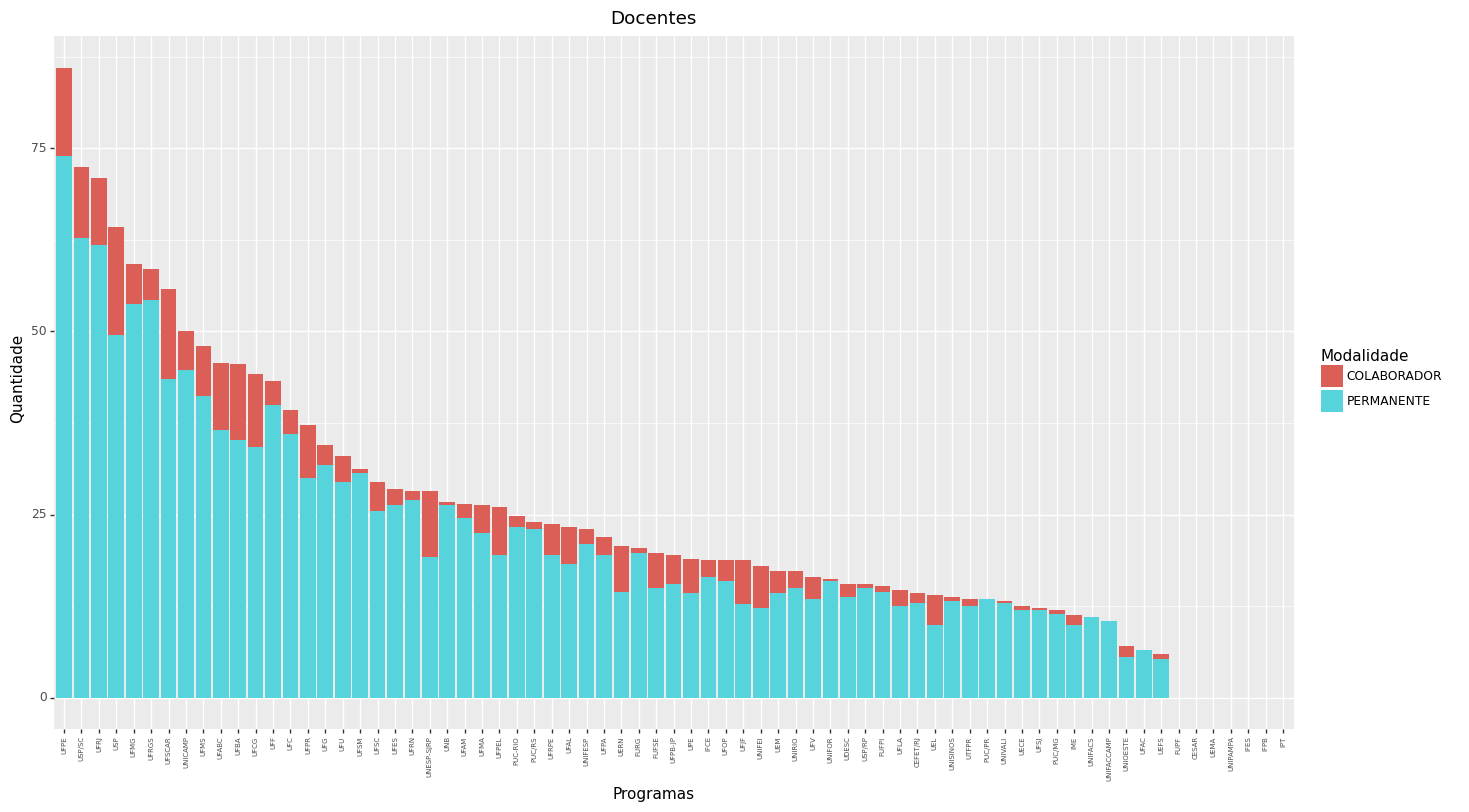

<ggplot: (8765916399865)>

In [16]:
plotDocentes(sumario_docentes, "Docentes")

##Teses

###Teses de doutorado (por ano)

/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


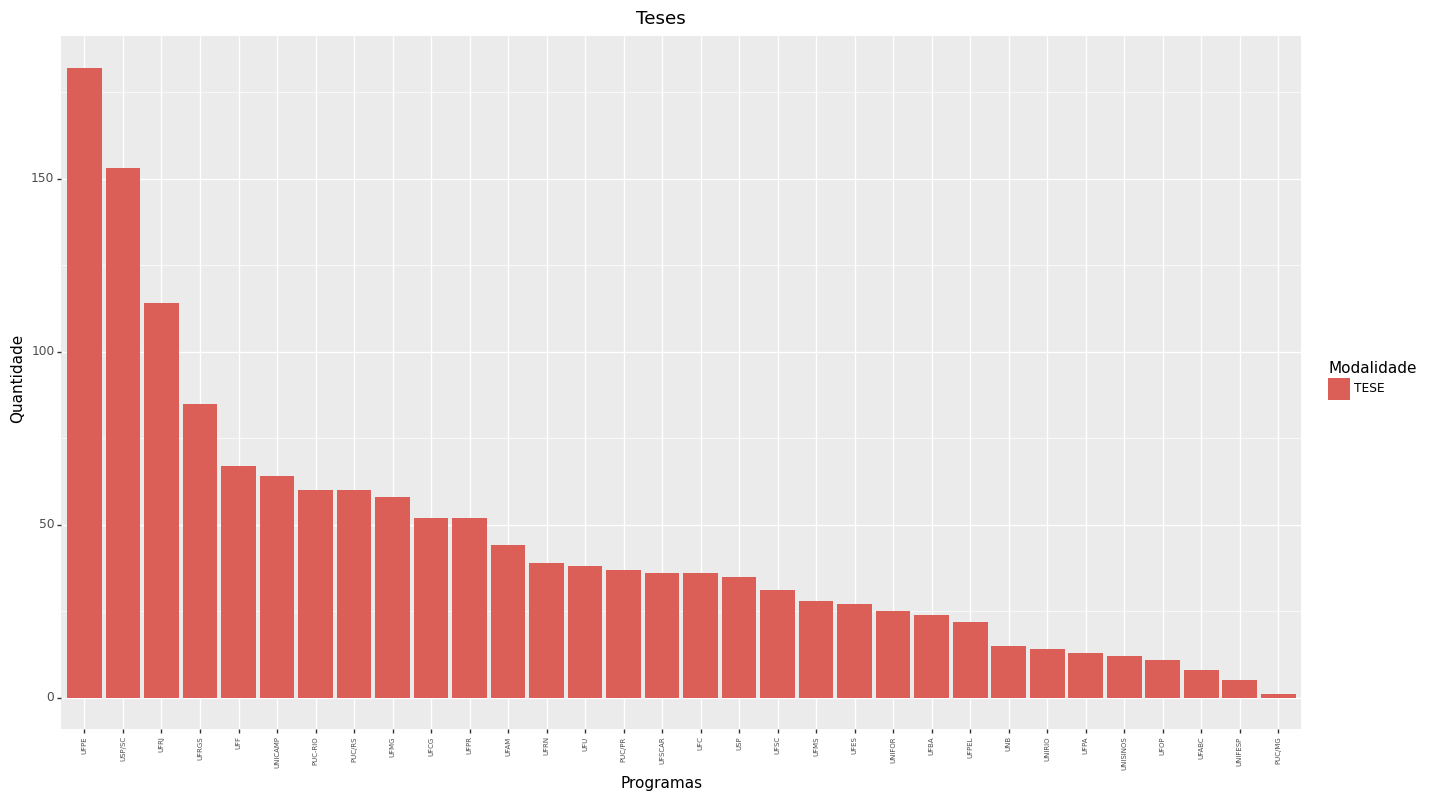

<ggplot: (8765913307241)>

In [17]:
plotTCC(sumario_TCC, "TESE", "Teses")

###Teses de doutorado por docente (por ano)

/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


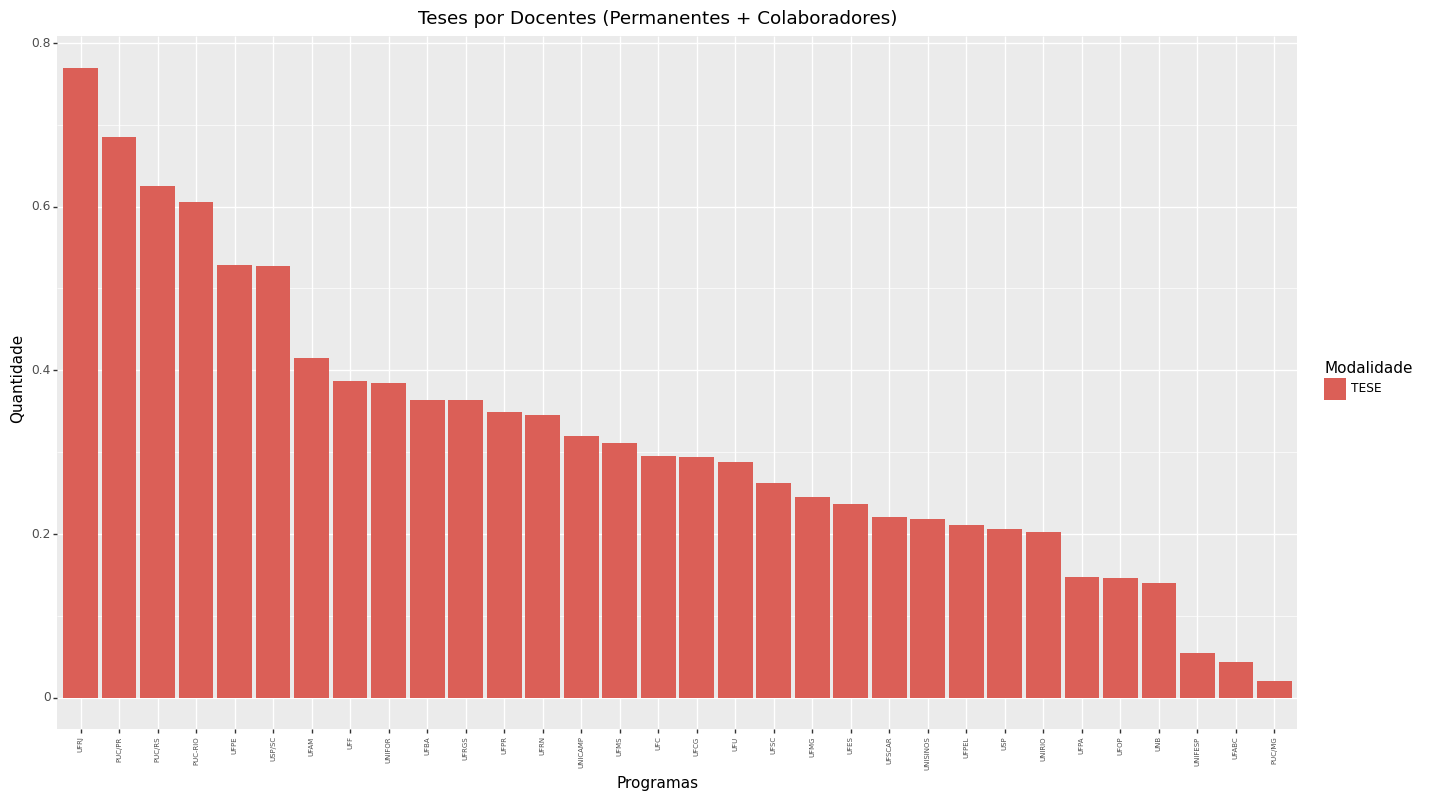

<ggplot: (8765913299401)>

In [18]:
plotTCC(ponderar_por_docs(sumario_TCC, sumario_docentes, ["TESE"]), "TESE", "Teses por Docentes (Permanentes + Colaboradores)")

##Dissertações

###Programas com mestrado – Total de Dissertações defendidas (por ano)

/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


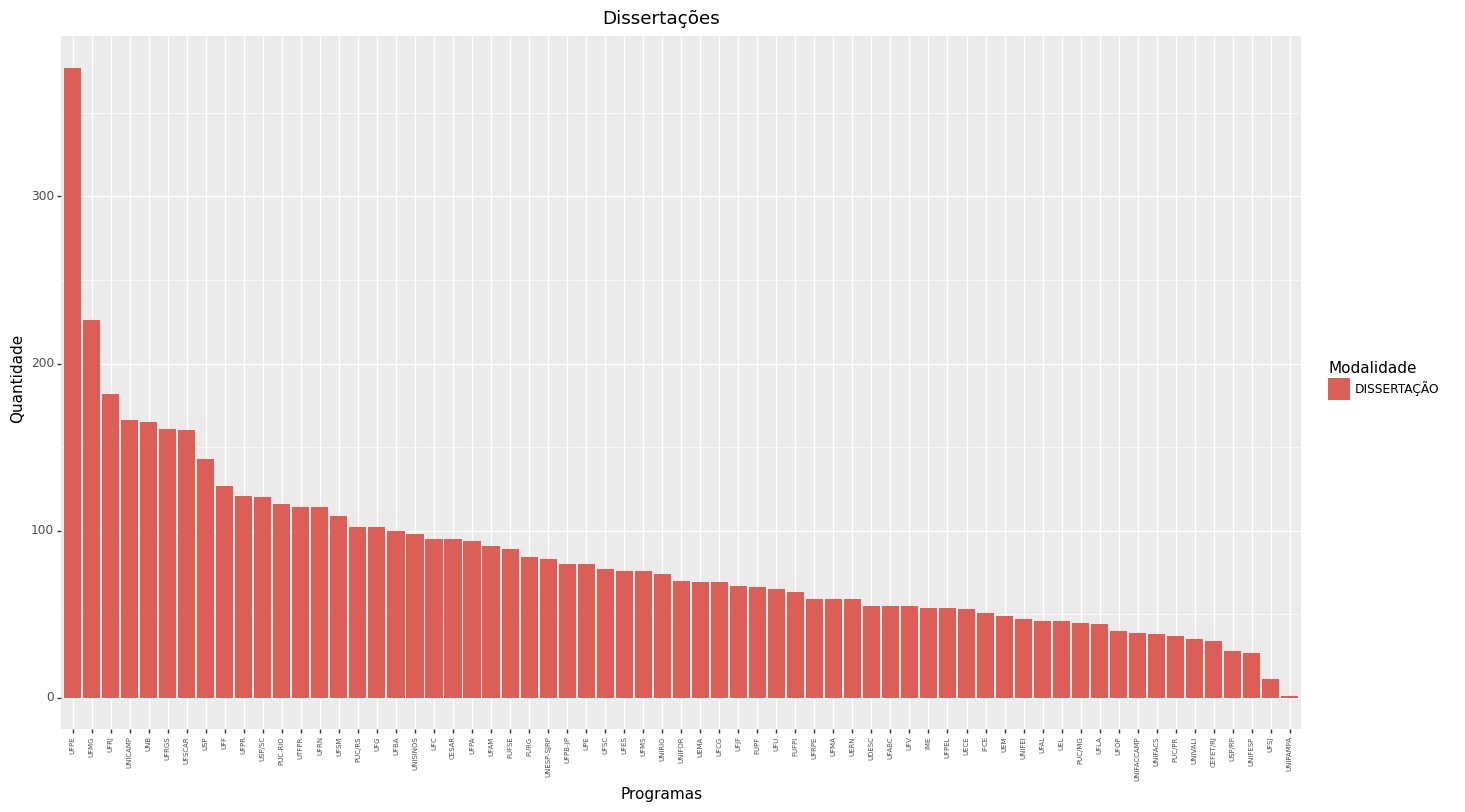

<ggplot: (8765913228405)>

In [19]:
plotTCC(sumario_TCC, "DISSERTAÇÃO", "Dissertações")

###Programas com mestrado – Total de Dissertações defendidas por docente (por ano)

/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):
/usr/local/lib/python3.7/dist-packages/plotnine/layer.py:452: PlotnineWarning: geom_bar : Removed 2 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


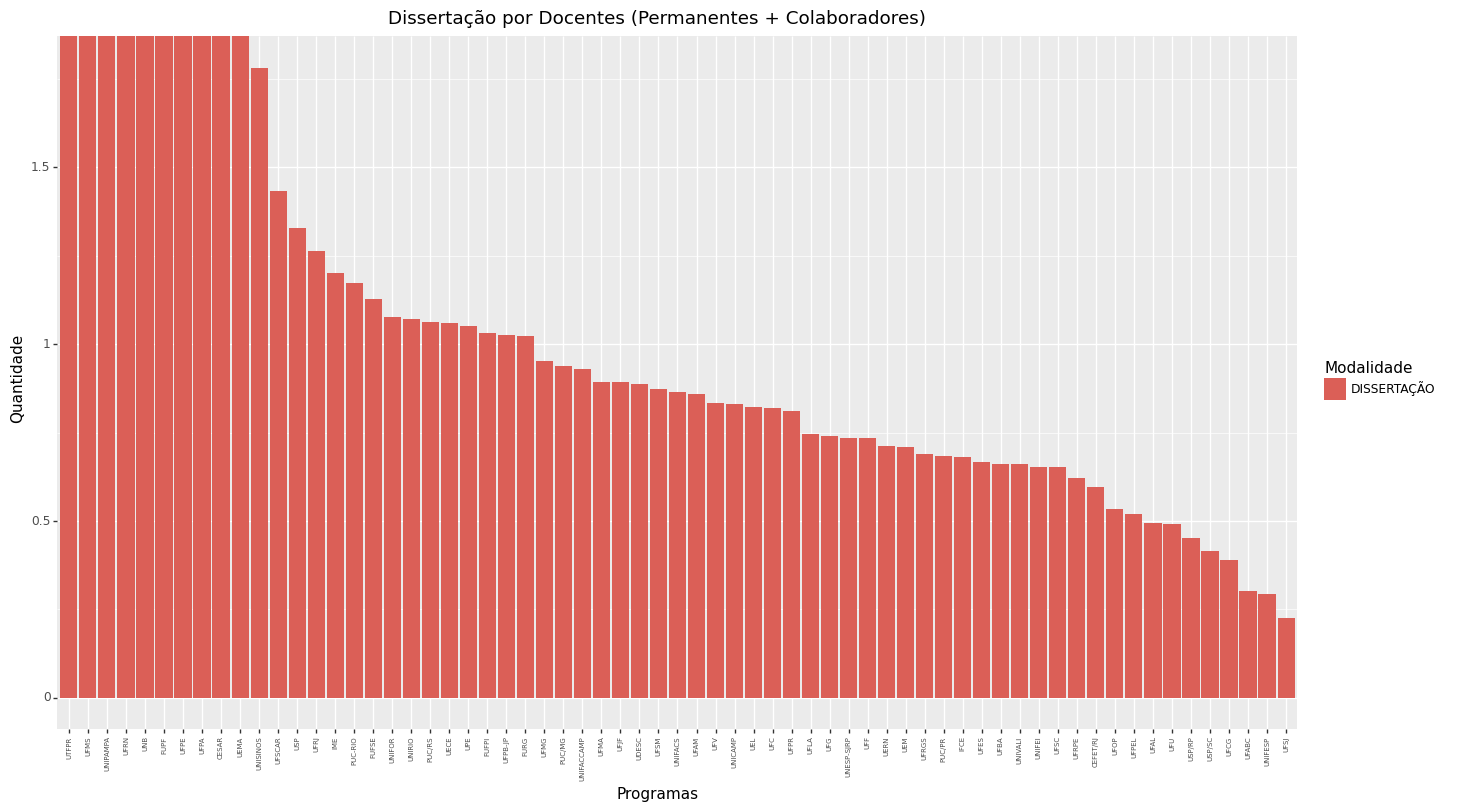

<ggplot: (8765913063797)>

In [20]:
plotTCC(ponderar_por_docs(sumario_TCC, sumario_docentes, ["DISSERTAÇÃO"]), "DISSERTAÇÃO", "Dissertação por Docentes (Permanentes + Colaboradores)")

##Periódicos

###IRestrito em periódicos por docente (por ano)

/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


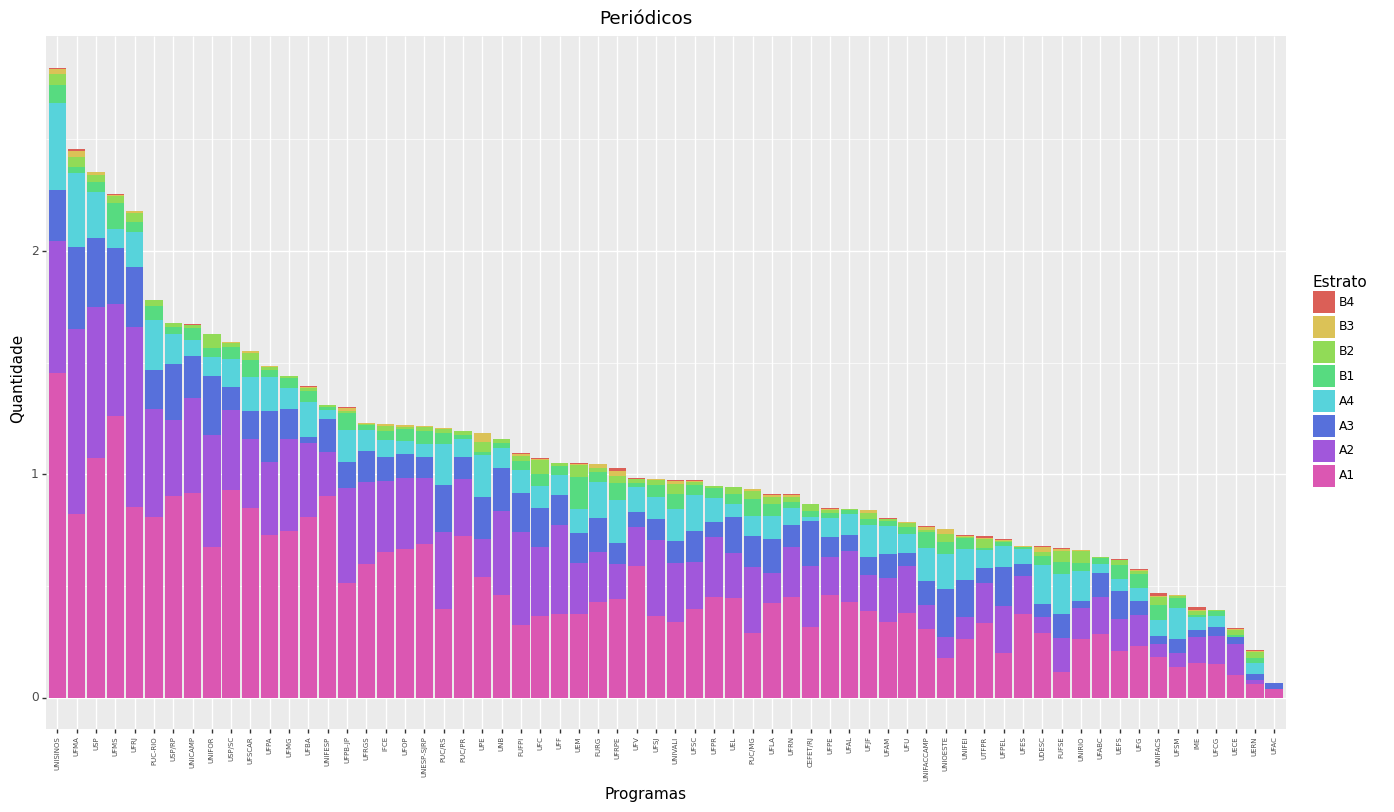

<ggplot: (8765912976429)>

In [21]:
plotPublicacaoQualis(ponderar_por_docs(sumario_prod, sumario_docentes, estratos), "Periódicos", lambda e: e["Qte"] * pesos[e["Estrato"]])

###IRestrito em periódicos por docente (por ano) – sem ESWA, JSS, Neurocomputing, Information Sciences

In [22]:
### Todo